<h1>Weather on Mars - Training Notebook</h1>
<h2>Training for prediction of temperature based on empirical data collected by Curiosity Mars Rover</h2>

In [ ]:
runLocallyOrOnDrive = 'Drive' # 'Drive' or 'Local', this variable only saves the prediction model to drive or local
#if 'Local' change the paths below to local paths e.g.  r'C:/Users/..'

In [ ]:
#@title Connect to Google Drive if runLocallyOrOnDrive=='Drive'
if runLocallyOrOnDrive == "Drive":
  from google.colab import drive
  drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#@title Change these file paths to your respective
#Google drive folder, but it can also be local e.g. on your C-disk
if runLocallyOrOnDrive == 'Local':
    saveModelPath = r'/media/../model.json' # create Alphabet folder on disk
    saveModelPathH5 = r'media/../model.h5'    
    
elif runLocallyOrOnDrive == 'Drive': 
    saveModelPath = r'/content/../model.json' # create Alphabet folder on disk
    saveModelPathH5 = r'/content/../model.h5'

In [ ]:
#@title Import libraries
# # If you want to loads file, upload to drive and run the following
import urllib, json

# import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.layers import Bidirectional,LSTM,Dense,Flatten,Conv1D,MaxPooling1D,Dropout,RepeatVector
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [ ]:
loadHistoricalDataFrom = "API" # "Drive", "API" and "HBASE" work

In [ ]:
#@title Import more libraries if HBASE if choosen  
if loadHistoricalDataFrom == "HBASE":
  #import hbase library
  #pip install hbase-python
  import hbase

In [ ]:
#@title Functions: Load Data 
def loadDataFromHBase():
    zk = '127.0.0.1:2181'
    hbaseData = []

    #got connection issue but followed instruction herein: https://github.com/3601314/hbase-python/issues/4 
    #added "table = table.replace('default:','')" on lineno 195 in 
    # ~/anaconda2/lib/python3.5/site-packages/hbase/client/region.py
    with hbase.ConnectionPool(zk).connect() as conn:
        table = conn['default']['archive']
        for row in table.scan():
            hbaseData.append(row)

    column_names = ["terrestrial_date", "min_temp", "max_temp"]
    data = pd.DataFrame(columns = column_names)

    for d in hbaseData:
        terrestrial_date = d.get("cf:wind_speed").decode("utf-8")
        min_temp = d.get("cf:season").decode("utf-8")
        max_temp = d.get("cf:ls").decode("utf-8")
        hbase_data = {'terrestrial_date': terrestrial_date, 'min_temp': min_temp, 'max_temp': max_temp}
        data = data.append(hbase_data, ignore_index=True)
    return data

def loadHistoricalData(): 
  if loadHistoricalDataFrom == "API":
    archiveUrl = 'https://pudding.cool/2017/12/mars-data/marsWeather.json'
    data = pd.DataFrame(pd.DataFrame(json.loads(urllib.request.urlopen(archiveUrl).read().decode('utf-8'))))
    return data
  elif loadHistoricalDataFrom == "Drive":
    data = pd.read_csv('/content/drive/My Drive/ID2221 Data Intensive Computing/Final Project/Data/mars-weather.csv')
    return data
  elif loadHistoricalDataFrom == "HBASE":
    data = loadDataFromHBase()
    return data    
    
# returns the (average) weather data for a top level key [sol] from [sol_keys]
def findAtAndPre(dictionary, key):
  value = dictionary.get(key)
  return {'AT': value.get('AT')['av'], 'PRE': value.get('PRE')['av']}

def loadRecentNDaysOfData(NDays): 
  # returns the data of the latest 7 days
  apiUrl = 'https://api.nasa.gov/insight_weather/?api_key=DEMO_KEY&feedtype=json&ver=1.0'
  jsonApi = json.loads(urllib.request.urlopen(apiUrl).read())

  dfApi = pd.DataFrame({key: findAtAndPre(jsonApi, key) for key in jsonApi.get('sol_keys')})
  return dfApi

In [ ]:
data = loadHistoricalData()

In [ ]:
data['min_temp'] = pd.to_numeric(data['min_temp'], downcast="float")
data['max_temp'] = pd.to_numeric(data['max_temp'], downcast="float")

data['avg_temp'] = data[['min_temp', 'max_temp']].mean(axis=1)
data['terrestrial_date']=pd.to_datetime(data['terrestrial_date'])

In [ ]:
df_avg_temp=pd.DataFrame(list(data['avg_temp']), index=data['terrestrial_date'], columns=['temp'])
df_avg_temp.fillna(data['avg_temp'].mean(),inplace=True)

In [ ]:
scaler=MinMaxScaler(feature_range=(-1,1))
scData =scaler.fit_transform(df_avg_temp)

windowsDays=7 
outputs=[]
inputs=[]

for i in range(len(scData)-windowsDays): #create the 7 day windows for training 
    inputs.append(scData[i:i+windowsDays])
    outputs.append(scData[i+windowsDays])

In [ ]:
outputs=np.asanyarray(outputs)
inputs=np.asanyarray(inputs)

trainingDays = int(np.round(len(inputs)*0.85,0)) #split the training data so that we have some test data below
# NOTE that we will also have validation data in the training

tr_x=inputs[:trainingDays,:,:]
tr_y=outputs[:trainingDays]

tst_x=inputs[trainingDays:,:,:]
tst_y=outputs[trainingDays:]

In [ ]:
model=keras.Sequential([
                  LSTM(128,activation='relu',input_shape=(windowsDays,1), return_sequences=True),
                  Bidirectional(LSTM(64,activation='relu')), #train two instead of one LSTMs on the input sequence
                  Dense(1)
                  ]
                  )
model.compile(optimizer='adam',loss='mse', metrics=['MeanAbsoluteError'])

In [ ]:
# early_stop=EarlyStopping(monitor='val_loss',patience=5)
history = model.fit(tr_x,tr_y,epochs=10,verbose=1,validation_split=0.15)#,callbacks=[early_stop]) #validation data split at 15%

Epoch 1/10
53/53 [==============================] - 1s 26ms/step - loss: 0.0533 - mean_absolute_error: 0.1641 - val_loss: 0.0143 - val_mean_absolute_error: 0.0914
Epoch 2/10
53/53 [==============================] - 1s 18ms/step - loss: 0.0176 - mean_absolute_error: 0.0959 - val_loss: 0.0144 - val_mean_absolute_error: 0.0916
Epoch 3/10
53/53 [==============================] - 1s 18ms/step - loss: 0.0171 - mean_absolute_error: 0.0930 - val_loss: 0.0138 - val_mean_absolute_error: 0.0907
Epoch 4/10
53/53 [==============================] - 1s 19ms/step - loss: 0.0165 - mean_absolute_error: 0.0907 - val_loss: 0.0132 - val_mean_absolute_error: 0.0886
Epoch 5/10
53/53 [==============================] - 1s 19ms/step - loss: 0.0166 - mean_absolute_error: 0.0922 - val_loss: 0.0133 - val_mean_absolute_error: 0.0893
Epoch 6/10
53/53 [==============================] - 1s 19ms/step - loss: 0.0163 - mean_absolute_error: 0.0903 - val_loss: 0.0132 - val_mean_absolute_error: 0.0896
Epoch 7/10
53/53 [====

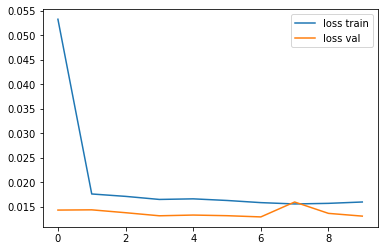

In [ ]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss val')
plt.legend();

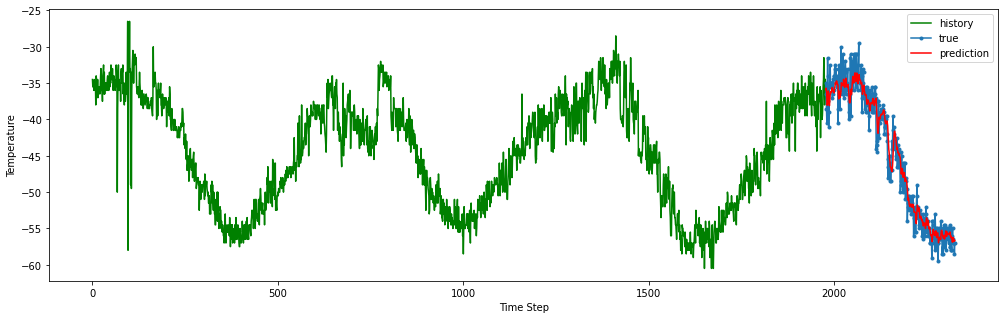

In [ ]:
trained = scaler.inverse_transform(tr_y)
predicted=scaler.inverse_transform(model.predict(tst_x))
actual=scaler.inverse_transform(tst_y)

plt.figure(figsize=(17,5))
plt.plot(np.arange(0, len(tr_y)), trained, 'g', label="history")
plt.plot(np.arange(len(tr_y), len(tr_y) + len(tst_y)), actual, marker='.', label="true")
plt.plot(np.arange(len(tr_y), len(tr_y) + len(tst_y)), predicted, 'r', label="prediction")
plt.ylabel('Temperature')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
#serialize mode to JSON
from keras.models import model_from_json

model_json = model.to_json()
with open(saveModelPath,"w") as json_file:
  json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(saveModelPathH5)
print("Saved model to disk")

Saved model to disk


In [ ]:
#@title Load Model JSON for testing
#serialize mode to JSON
from tensorflow.keras.models import model_from_json
json_file =  open(saveModelPath,"r")
model_json = json_file.read()
json_file.close()
model_fromDisk = model_from_json(model_json)

#load weights into the new model 
model_fromDisk.load_weights(saveModelPathH5)
print("loaded from disk")

loaded from disk


Here is how the model from disk predicts:

In [ ]:
scaler.inverse_transform(model_fromDisk.predict(tst_x))[0]

array([-35.903385], dtype=float32)

In comparison to above i.e. the same. Thereby, loading from disk works fine:

In [ ]:
predicted[0]

array([-35.903385], dtype=float32)